In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

In [5]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
df_wine.columns=['Class label','Alcohol','Malic acid','Ash',
                'Alcalinity of ash','Magnesium','Total phenols',
                'Flavanoids','Nonflavanoid phenols','Proanthocyanins',
                'Color intensity','Hue','OD280/OD315 of diluted wines',
                'Proline']

In [9]:
print('Class labels',np.unique(df_wine["Class label"]))

Class labels [1 2 3]


In [10]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [14]:
#划分训练集和测试集
from sklearn.cross_validation import train_test_split
x,y = df_wine.iloc[:,1:], df_wine.iloc[:,0]

In [17]:
X_train,X_test,y_train,y_test = \
    train_test_split(x,y,test_size=0.3,random_state=0)

In [19]:
X_train.shape,X_test.shape

((124, 13), (54, 13))

In [20]:
#标准化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [22]:
#L1正则化
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1',C=0.1)
lr.fit(X_train_std,y_train)
print('Train accuracy: ',lr.score(X_train_std,y_train))

Train accuracy:  0.983870967742


In [24]:
lr.coef_

array([[ 0.27999161,  0.        ,  0.        , -0.02793607,  0.        ,
         0.        ,  0.70996133,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.2367753 ],
       [-0.64404654, -0.06883421, -0.05718545,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92659512,
         0.06021885,  0.        , -0.37108755],
       [ 0.        ,  0.06161864,  0.        ,  0.        ,  0.        ,
         0.        , -0.63570042,  0.        ,  0.        ,  0.49793361,
        -0.35828002, -0.57147428,  0.        ]])

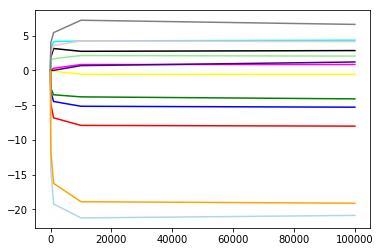

In [36]:
fig = plt.figure()
ax=plt.subplot(111)
colors=['blue','green','red','cyan','magenta','yellow','black',
        'pink','lightgreen','lightblue','gray','indigo','orange']
weights,params=[],[]
for c in np.arange(-4,6,dtype=float):
    lr = LogisticRegression(penalty='l1',C=10**c,random_state=0)
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
for column,color in zip(range(weights.shape[1]),colors):
                     plt.plot(params,weights[:,column],
                             label=df_wine.columns[column+1],
                             color=color)

plt.show()

In [76]:
#序列特征选择算法，序列后向选择算法(Sequential Backward Selection, SBS)
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self,estimator,k_features,scoring=accuracy_score,
                test_size = 0.25, random_state=1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self,X,y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X,y,test_size = self.test_size,random_state =self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        self.scores_ = [score]
        
        while dim>self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_,r = dim-1):
                score=self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self,X):
        return X[:,self.indeces_]
    
    def _calc_score(self,X_train,y_train,X_test,y_test,indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test,y_pred)
        return score


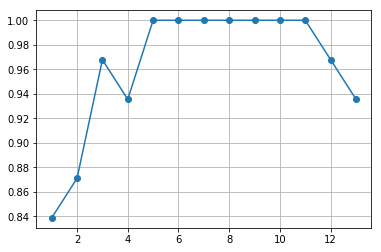

In [77]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn,k_features=1)
sbs.fit(X_train_std,y_train)

k_feat = [ len(k) for k in sbs.subsets_  ]
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim=([0.7,1.1])
plt.grid()
plt.show()

In [84]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])


Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [81]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 12),
 (0, 1, 2, 3, 6, 7, 8, 10, 12),
 (0, 1, 2, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 10, 12),
 (0, 1, 3, 10, 12),
 (0, 1, 10, 12),
 (0, 1, 10),
 (0, 10),
 (0,)]

In [86]:
#验证knn在测试集的表现
knn.fit(X_train_std,y_train)
print('Training accuracy:',knn.score(X_train_std,y_train))
print('Test accuracy:',knn.score(X_test_std,y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [88]:
knn.fit(X_train_std[:,k5],y_train)
print('Training accuracy',knn.score(X_train_std[:,k5],y_train))
print('Test accuracy:',knn.score(X_test_std[:,k5],y_test))

Training accuracy 0.959677419355
Test accuracy: 0.962962962963


In [91]:
#通过随机森林判定特征的重要性
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000,random_state=0,n_jobs=-1)
forest.fit(X_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,20,feat_labels[f],importances[indices[f]]))

 1) Alcohol              0.182483
 2) Malic acid           0.158610
 3) Ash                  0.150948
 4) Alcalinity of ash    0.131987
 5) Magnesium            0.106589
 6) Total phenols        0.078243
 7) Flavanoids           0.060718
 8) Nonflavanoid phenols 0.032033
 9) Proanthocyanins      0.025400
10) Color intensity      0.022351
11) Hue                  0.022078
12) OD280/OD315 of diluted wines 0.014645
13) Proline              0.013916


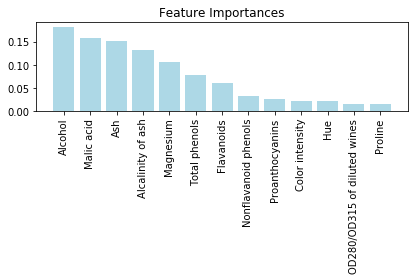

In [93]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(X_train.shape[1]),feat_labels,rotation=90)
plt.tight_layout()